In [1]:
import sqlite3
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from bgfunc import *

loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.5, for 906 words
loading data/LIWC/LIWC2007_English100131_words.dic
loading LIWC with stopVal=0.0, for 4483 words
loading LabMT with stopVal=1.0, for 3731 words
loading ANEW with stopVal=1.0, for 765 words


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load SQLite database 

In [2]:
dbfile = 'project_july26.db' # only project_july26.db has up-to-date word feats
conn = sqlite3.connect(dbfile)

## Analysis parameters 

Which condition are we studying?  Are there any cutoffs based on testing?  
What sort of analyses or models do we want to run?

In [3]:
platform = 'tw' # ig = instagram, tw = twitter
condition = 'depression' # depression, pregnancy, ptsd, cancer

In [4]:
specs = analysis_specifications(platform, condition)

platform_long = specs['plong'][platform]
gb_types = specs['gb_types'][platform]
fields = specs['fields'][platform] 
test_name = specs['test_name'][condition]
test_cutoff = specs['test_cutoff'][condition]
photos_rated = specs['photos_rated'][condition]
has_test = specs['has_test'][condition]

clfs = ['rf'] # lr = logistic regression, rf = random forests, svc = support vector
periods = ['before','after']
turn_points = ['from_diag','from_susp']

#################
#
# INSTAGRAM ONLY 
# 
#################
additional_data = True # (instagram only) do we also get photo ratings? (This is proxy for limit_date_range in places)

include_filter = False # (instagram only) include binary indicator of filter use? 

include_face_data = False # (instagram only) include has_face and face_ct? 

get_ratings_correlation = False # (instagram only) gets inter-rater correlation averages for each rated variable 

compare_ig_filters = False # (nstagram only) compares use of filters between target and control pops

#################
#
# TWITTER ONLY 
# 
#################
populate_wordfeats_db = False # (twitter only) generates word features from reagan code 


#################
#
# ALL PLATFORMS 
# 
#################
impose_test_cutoff = True # do we want to limit target pop based on testing cutoff (eg. cesd > 21)?

limit_date_range = False # do we want to restrict posts by date range? 

posting_cutoff = False # Drops usernames with fewer than (mean - 0.5std) total posts (for mcmc p-val improvement)

report_sample_size = False # simple reporting feature for sample size

report_sm_disq = False # reports #/% of subjects disqualified for refusing to share social media data

path_head = '/'.join(['data-files',condition,platform])+'/'

load_from = 'pickle' # None, file, pickle :: loads masters from pickled file, or just masters from csv

write_to = None # None, file, pickle  :: writes initial data (prepare_raw_data()) to csv or pickle

final_pickle = False # pickles entire data dict after all masters are created

make_hourly_plot = False # make plot of aggregated hourly posting for target vs control?

run_master = True 
run_subsets = True
run_separate_pca = True

action_params = {
    'create_master': True, 
    'save_to_file' : True, 
    'density' : False, 
    'ml' : True, 
    'nhst' : True, 
    'corr' : False, 
    'print_corrmat' : False,
    'tall_plot': True,
    'acc_avg': 'binary',
    'use_ttest':False,
    'best_pca':10
}

params = define_params(condition, test_name, test_cutoff, impose_test_cutoff,
                       platform, platform_long, fields, photos_rated, has_test, additional_data)

### hourly_plot sets local timestamp for every post 
The timezone acquisition happens in get_timezones.py.  That's not currently imported here, but it should get merged eventually.  to_localtime_wrapper() assumes that the 'tz' field in meta_tw is populated as best as can be done.
Remember not all Twitter accounts have time zone info, and Instagram has none at all, aside from occassional lat/lon data (which we didn't bother to try and convert).  
  
### WARNING: hourly_plot() is not well-constructed, and rewrites meta_tw, leaving some odd results!
In particular, None gets replaced with '' for some reason, and this screws up other things.  Be careful.

In [5]:
if make_hourly_plot:
    hourly_plot(conn)

In [6]:
# printout showing sample sizes for target and control groups
if report_sample_size:
    report_sample_sizes(params, conn, condition, platform_long, test_cutoff, test_name)

## Load ready data, or prepare raw data

Set load_from to determine action here.  

In case you don't have a pickled data dict or saved csv, or if you want to make a new one, the next block will:

- Pulls data from db
- Aggregates in buckets (day, week, user)
- Creates before/after diag/susp date subsets along with whole

Otherwise we load existing cleaned/aggregated data from pickle/csv

In [5]:
if not load_from: # construct data dict from raw data
    data = make_data_dict(params, condition, test_name, conn)
    prepare_raw_data(data, platform, params, conn, gb_types, condition, 
                     periods, turn_points, posting_cutoff,
                     additional_data=additional_data, include_filter=include_filter, limit_date_range=limit_date_range)
else: # load data dict from saved file
    #data = data_loader(load_from, condition, platform, path_head)
    data = pickle.load(open("{path}{cond}_{pl}_data.p".format(path=path_head,
                                                              cond=condition,
                                                              pl=platform), "rb" ) )

### This next section generates word features from Andy Reagan's code

Only set populate_wordfeats_db = True if you need to redo the features for some reason!
    

In [8]:
if populate_wordfeats_db:
    create_word_feats_wrapper(['target','control'], gb_types, data, condition, conn, 
                              write_to_db=True, testing=True)                        

## Construct master dataset & run analyses

Possible actions:
- generate master data
- save to disk
- plot target vs control densities for each variable
- correlation plot
- ML modeling
- NHST


Merge to master: MAIN created_date
master created_date shape: (102215, 88)

Building ML models...

TN :: (12840.0, 0.0)
PNEG :: (17341.0, 0.0)
NEG :: (15418.0, 0.0)
NPV :: (0.74, 0.0)
SPECIFICITY :: (0.833, 0.0)
PRECISION :: (0.807, 0.0)
RECALL :: (0.705, 0.0)
F1 :: (0.752, 0.0)


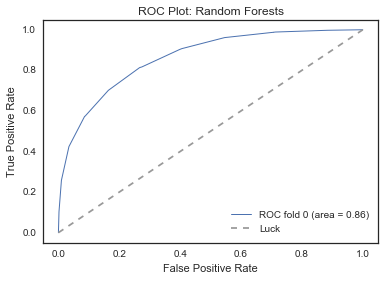

UNIT OF OBSERVATION: CREATED_DATE


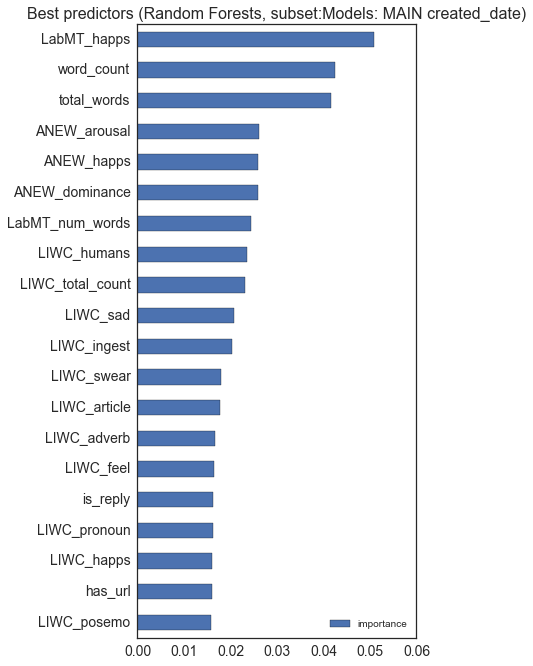

Out of 100 random observations...

n1 50.0
n0 50.0
36.0 positive IDs
8.0 false alarms
14.0 false negatives
42.0 negative IDs

reconstituted total: 100.0

Merge to master: MAIN weekly
master weekly shape: (29328, 86)

Building ML models...

TN :: (4265.0, 0.0)
PNEG :: (5638.0, 0.0)
NEG :: (4828.0, 0.0)
NPV :: (0.756, 0.0)
SPECIFICITY :: (0.883, 0.0)
PRECISION :: (0.822, 0.0)
RECALL :: (0.654, 0.0)
F1 :: (0.729, 0.0)


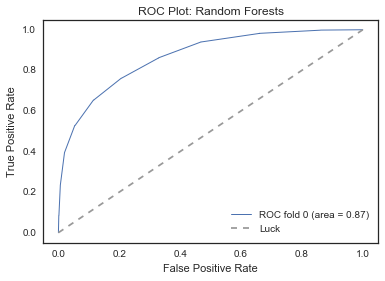

UNIT OF OBSERVATION: WEEKLY


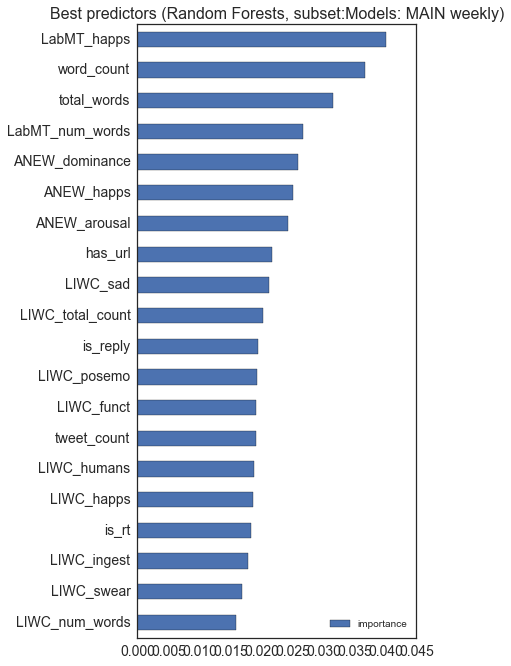

Out of 100 random observations...

n1 46.0
n0 54.0
31.0 positive IDs
6.0 false alarms
15.0 false negatives
48.0 negative IDs

reconstituted total: 100.0


In [6]:
if run_master:
    master = data['master']
    target = data['target']['gb']
    control = data['control']['gb'] 
    report = 'MAIN'
    
    if action_params['create_master']:
        master['model'] = {}

    for gb_type in ['created_date', 'weekly']:

        master_actions(master, target, control, condition, platform, 
                       params, gb_type, report, action_params, clfs, additional_data, posting_cutoff)

## Subset master actions

Same as above block, but for subsets, eg. target before diag_date vs controls

Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_DIAG  Groupby: CREATED_DATE (PCA:True)

Merge to master: before-from_diag created_date
master created_date shape: (74990, 88)

Building ML models...

LIWC_total_count    0.153665
LIWC_humans         0.150854
LIWC_sad            0.150663
LIWC_article        0.149993
LabMT_num_words     0.149625
LIWC_ingest         0.146369
LIWC_posemo         0.145666
LIWC_past           0.144652
LIWC_feel           0.144560
LIWC_swear          0.143699
Name: PCA_0, dtype: float64

ANEW_happs        0.487026
ANEW_dominance    0.483084
ANEW_arousal      0.464900
LabMT_happs       0.300652
LIWC_happs        0.210664
word_count        0.198272
LIWC_ipron        0.146328
ANEW_num_words    0.099121
LIWC_conj         0.085437
LIWC_number       0.078604
Name: PCA_1, dtype: float64

is_rt             0.535423
is_reply          0.477270
word_count        0.359073
LIWC_i            0.200039
ANEW_dominance    0.181505
ANEW_happs        0.178422
ANEW_arousal      0

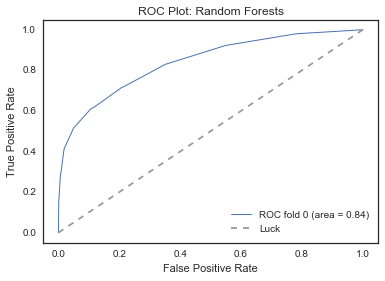


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE


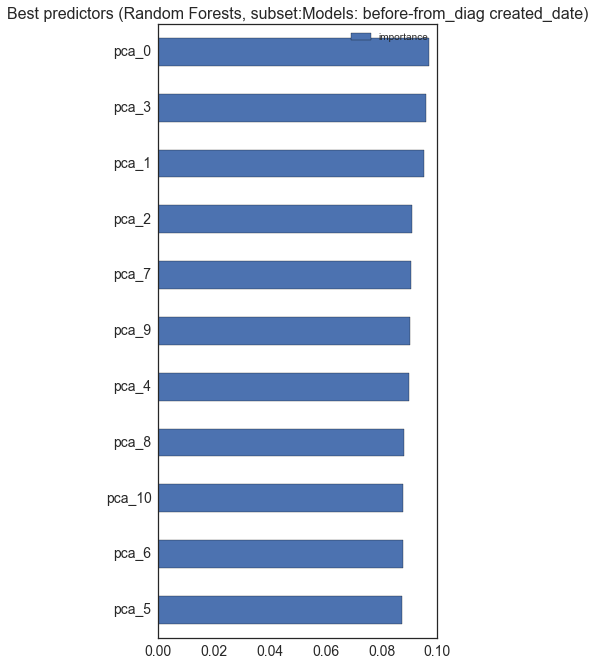

Out of 100 random observations...

n1 32.0
n0 68.0
17.0 positive IDs
3.0 false alarms
15.0 false negatives
65.0 negative IDs

reconstituted total: 100.0
Reporting for: SUBSETS
Period: BEFORE  Focus: FROM_DIAG  Groupby: WEEKLY (PCA:True)

Merge to master: before-from_diag weekly
master weekly shape: (22451, 86)

Building ML models...

LIWC_total_count    0.137357
LIWC_humans         0.137235
LIWC_sad            0.137140
LIWC_article        0.136771
LabMT_num_words     0.135808
LIWC_ingest         0.135575
LIWC_posemo         0.135350
LIWC_feel           0.135049
LIWC_past           0.134573
LIWC_swear          0.134295
Name: PCA_0, dtype: float64

ANEW_happs        0.499394
ANEW_dominance    0.495952
ANEW_arousal      0.474765
LabMT_happs       0.301653
LIWC_happs        0.217806
word_count        0.188993
LIWC_ipron        0.180868
LIWC_adverb       0.066953
tweet_count       0.064433
LIWC_number       0.062505
Name: PCA_1, dtype: float64

is_rt             0.603786
is_reply          0

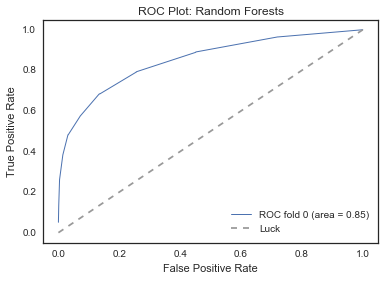


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: WEEKLY


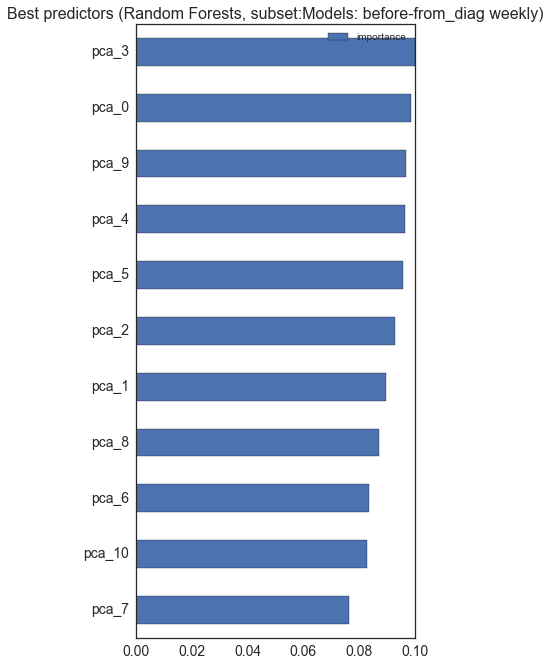

Out of 100 random observations...

n1 29.0
n0 71.0
14.0 positive IDs
2.0 false alarms
15.0 false negatives
69.0 negative IDs

reconstituted total: 100.0


In [7]:
use_pca = True # should models be fit using orthogonal pca components?

if run_subsets:
    for period in ['before']:
        if action_params['create_master']:
            data['master'][period] = {}

        for turn_point in ['from_diag']:    
            if action_params['create_master']:
                data['master'][period][turn_point] = {}

            master = data['master'][period][turn_point]
            target = data['target'][period][turn_point]['gb']
            control = data['control']['gb'] 
            report = '{}-{}'.format(period,turn_point)

            if action_params['create_master']:
                master['model'] = {}

            for gb_type in ['created_date','weekly']:
                print 'Reporting for: SUBSETS'
                print 'Period: {}  Focus: {}  Groupby: {} (PCA:{})'.format(period.upper(), turn_point.upper(), gb_type.upper(), use_pca)
                # merge target, control, into master
                master_actions(master, target, control, condition, platform, 
                               params, gb_type, report, action_params, clfs, additional_data, posting_cutoff,
                               use_pca)

### Pickle entire data dict

Set final_pickle = True to save to disk  
Note that this is separate from saving individual files to csv, which is controlled by the save_to_file flag in action_params.

In [8]:
if final_pickle:
    pickle.dump( data, open( "{path}{cond}_{pl}_data.p".format(path=path_head,cond=condition,pl=platform), "wb" ) )

### Within-target before vs after

This compares before/after diag/susp dates within target population.  
Basically just a check to see whether the population looks different based on a given change point

In [11]:
# no username gb because you don't have the infrastructure built (you'd need to split bef/aft before the username gb)
# but at any rate, this is just a check...and per-username groupby has the lowest sample size anyhow
if run_before_after:
    for gb_type in ['created_date','weekly']: 
        before_vs_after(data['target']['gb'], gb_type, platform, condition, params['vars'][platform], action_params)

### PCA

PCA below only runs on master (ie. not before/after diag/susp vs control).

Note: You can fold in PCA into the master_actions() sequence, above, by adding the parameter use_pca=True  
This will only run PCA and PCA components as predictors, though.  
Currently you can't run both PCA and non-PCA when modeling, simulataneously - you did this mainly to cut down on the length of any one given code block output.  
You may find PCA particularly helpful for the timeline groups analysis...

RUNNING PCA: created_date

LIWC_total_count    0.147312
LIWC_humans         0.146013
LIWC_sad            0.146011
LIWC_article        0.145458
LabMT_num_words     0.144257
LIWC_ingest         0.142867
LIWC_posemo         0.142329
LIWC_feel           0.141540
LIWC_past           0.141365
LIWC_swear          0.141139
Name: PCA_0, dtype: float64

ANEW_happs        0.490310
ANEW_dominance    0.487589
ANEW_arousal      0.468382
LabMT_happs       0.300805
word_count        0.213380
LIWC_happs        0.204056
LIWC_ipron        0.163523
tweet_count       0.077184
LIWC_conj         0.066572
LIWC_adverb       0.065967
Name: PCA_1, dtype: float64

is_rt             0.591629
is_reply          0.545541
word_count        0.313244
LIWC_i            0.180996
ANEW_dominance    0.161277
ANEW_happs        0.155956
ANEW_arousal      0.153293
LIWC_ppron        0.150770
has_url           0.130178
LIWC_ipron        0.101794
Name: PCA_2, dtype: float64

has_url           0.409027
tweet_count       0.290341
to

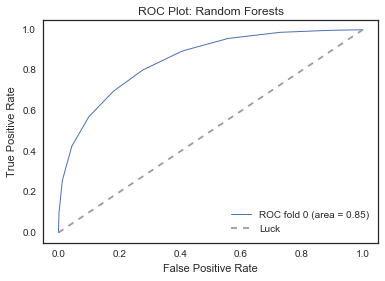


NOTE: ALL MODELS ON THIS RUN USE PCA COMPONENTS!

UNIT OF OBSERVATION: CREATED_DATE


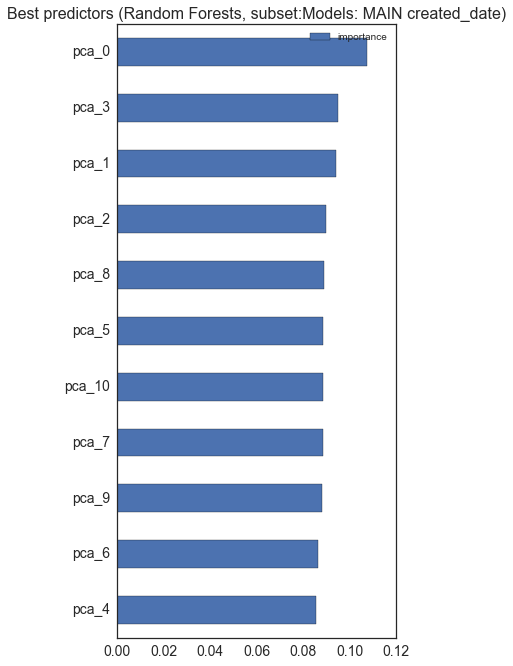

Out of 100 random observations...

n1 50.0
n0 50.0
35.0 positive IDs
9.0 false alarms
15.0 false negatives
41.0 negative IDs

reconstituted total: 100.0

LOGISTIC REGRESSION
UNIT OF MEASUREMENT: created_date

Optimization terminated successfully.
         Current function value: 0.674693
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               102215
Model:                          Logit   Df Residuals:                   102203
Method:                           MLE   Df Model:                           11
Date:                Fri, 29 Jul 2016   Pseudo R-squ.:                 0.02659
Time:                        14:59:23   Log-Likelihood:                -68964.
converged:                       True   LL-Null:                       -70848.
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|   

In [9]:
if run_separate_pca:
    master = data['master']
    report = 'MAIN'

    for gb_type in ['created_date']:

        print 'RUNNING PCA: {}'.format(gb_type)
        print
        model_df = {'name':'Models: {} {}'.format(report, gb_type),
                    'unit':gb_type,
                    'data':master[gb_type],
                    'features':params['vars'][platform][gb_type]['means'],
                    'target':'target',
                    'platform':platform,
                    'test_size':.3,
                    'acc_avg':'binary',
                    'best_pca_num_comp':action_params['best_pca'], # 69 for tw-MAIN-created_date, but even 2 works!
                    'kernel':'rbf',
                    'tall_plot':action_params['tall_plot'],
                    'rf_params': {'class_wt':'balanced',
                                  'max_feat':'sqrt',
                                  'n_est':10,
                                  'min_ss':2,
                                  'min_sl':1,
                                  'max_depth':None,
                                  'imp_cutoff':.015} # params optimized with 5-fold CV, see optimize_rf_hyperparams()
                   }

        excluded_set = params['model_vars_excluded'][platform][gb_type]

        output, pca_df, best_f1, master_results = make_models(model_df, clf_types=clfs, 
                                                           excluded_set=excluded_set, 
                                                           use_pca=True)
        
        save_master_to_file(additional_data, posting_cutoff, run_separate_pca, 
                            gb_type, report, condition, platform, pca_df)
        
        print
        print 'LOGISTIC REGRESSION'
        print logreg_wrapper(pca_df, gb_type, None, additional_data='pca')